# Import Necessary Libraries

In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import io
import seaborn as sns
import scikitplot as skplt
import tensorflow as tf

from tqdm import tqdm
from sklearn.utils import shuffle # Shuffle arrays or sparse matrices in a consistent way
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential, load_model
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Defining Labels

In [23]:
labels = ['no_tumor_augmented', 'tumor_augmented']

# Loading Dataset


In [24]:
X_train = [] #Training Dataset
Y_train = [] #Training Labels

image_size=200

for i in labels:
    folderPath = os.path.join('brain_tumor_mri_dataset_binary', 'Augmented', 'Train', i)
    for j in tqdm(os.listdir(folderPath)):
        image = cv2.imread(os.path.join(folderPath, j))
        image = cv2.resize(image, (image_size, image_size))
        X_train.append(image)
        if i == labels[0]:
            Y_train.append("No Tumor")
        else:
            Y_train.append("Tumor")
        
        
for i in labels:
    folderPath = os.path.join('brain_tumor_mri_dataset_binary', 'Augmented', 'Test', i)
    for j in tqdm(os.listdir(folderPath)):
        image = cv2.imread(os.path.join(folderPath, j))
        image = cv2.resize(image, (image_size, image_size))
        X_train.append(image)
        if i == labels[0]:
            Y_train.append("No Tumor")
        else:
            Y_train.append("Tumor")
        
#Image and Label is appended as list, now is to be converted into array
X_train = np.array(X_train)
Y_train = np.array(Y_train)

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:04<00:00, 232.83it/s]


In [25]:
print(X_train.shape) #No of sample = 12,000
print(Y_train.shape)

(12000, 200, 200, 3)
(12000,)


In [26]:
# Shuffling data
X_train, Y_train = shuffle(X_train, Y_train, random_state=42)

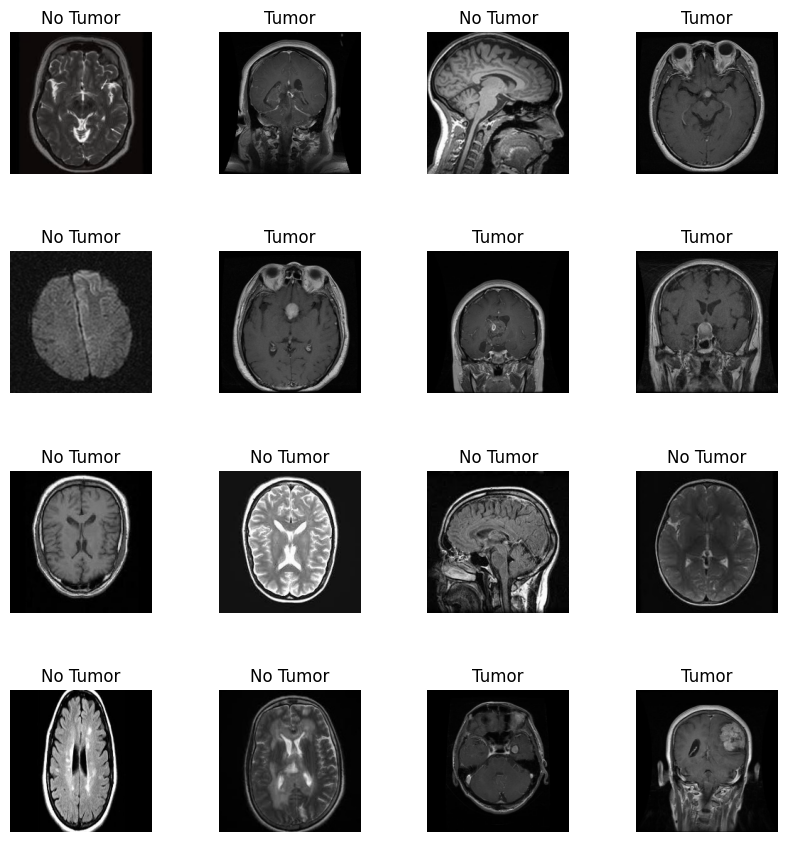

In [27]:
grid_width = 4
grid_height = 4
f, ax = plt.subplots(grid_width, grid_height)
f.set_size_inches(8, 8)

img_idx = 0
for i in range(0, grid_width):
    for j in range(0, grid_height):
        ax[i][j].axis('off')
        ax[i][j].set_title(Y_train[img_idx])
        ax[i][j].imshow(X_train[img_idx])
        img_idx += 1

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=0.55) 

# Splitting data into : Train, Test, Valid as 70, 20, 10 ratio

In [28]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

In [29]:
print(f"Number of Training examples = {X_train.shape[0]}")
print(f"Number of Validating examples = {X_valid.shape[0]}")
print(f"Number of Testing examples = {X_test.shape[0]}")

Number of Training examples = 8640
Number of Validating examples = 960
Number of Testing examples = 2400


# Converting String Label to categorical

In [30]:
# Convert labels to numerical values
y_train_new = []
y_valid_new = []
y_test_new = []

for i in Y_train:
    if i == "No Tumor":
        y_train_new.append(0)
    else:
        y_train_new.append(1)

for i in Y_valid:
    if i == "No Tumor":
        y_valid_new.append(0)
    else:
        y_valid_new.append(1)

for i in Y_test:
    if i == "No Tumor":
        y_test_new.append(0)
    else:
        y_test_new.append(1)

# Convert numerical labels to single-column arrays
Y_train = np.array(y_train_new)
Y_valid = np.array(y_valid_new)
Y_test = np.array(y_test_new)

# Simple CNN Model

In [37]:
def createModel():
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(3,3), activation='relu', input_shape=(200, 200, 3)))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()

    return model

In [38]:
model = createModel()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 198, 198, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 99, 99, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 97, 97, 64)        9280      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 46, 46, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 23, 23, 128)     

# Scaling Features : Train, Valid and Test 

In [35]:
# Scaling Train, Valid and Test Features
X_train_scaled = X_train.astype('float32')
X_valid_scaled = X_valid.astype('float32')
X_test_scaled = X_test.astype('float32')


X_train_scaled /= 255
X_valid_scaled /= 255
X_test_scaled /= 255

# Training the model

In [39]:
with tf.device('/CPU:0'):
    model.fit(x=X_train_scaled, y=Y_train,
                validation_data=(X_valid_scaled, Y_valid),
                batch_size=32,
                epochs=10,
                verbose=1)

Epoch 1/10
270/270 [==============================] - 281s 1s/step - loss: 0.2476 - accuracy: 0.9100 - val_loss: 0.1299 - val_accuracy: 0.9677
Epoch 2/10
270/270 [==============================] - 273s 1s/step - loss: 0.0776 - accuracy: 0.9735 - val_loss: 0.0715 - val_accuracy: 0.9833
Epoch 3/10
270/270 [==============================] - 268s 989ms/step - loss: 0.0427 - accuracy: 0.9872 - val_loss: 0.0521 - val_accuracy: 0.9865
Epoch 4/10
270/270 [==============================] - 249s 922ms/step - loss: 0.0342 - accuracy: 0.9891 - val_loss: 0.0658 - val_accuracy: 0.9844
Epoch 5/10
270/270 [==============================] - 240s 888ms/step - loss: 0.0158 - accuracy: 0.9947 - val_loss: 0.0779 - val_accuracy: 0.9833
Epoch 6/10
270/270 [==============================] - 236s 874ms/step - loss: 0.0169 - accuracy: 0.9944 - val_loss: 0.0605 - val_accuracy: 0.9896
Epoch 7/10
270/270 [==============================] - 238s 882ms/step - loss: 0.0040 - accuracy: 0.9988 - val_loss: 0.0946 - val_a

# Accuracy and Loss Visualization

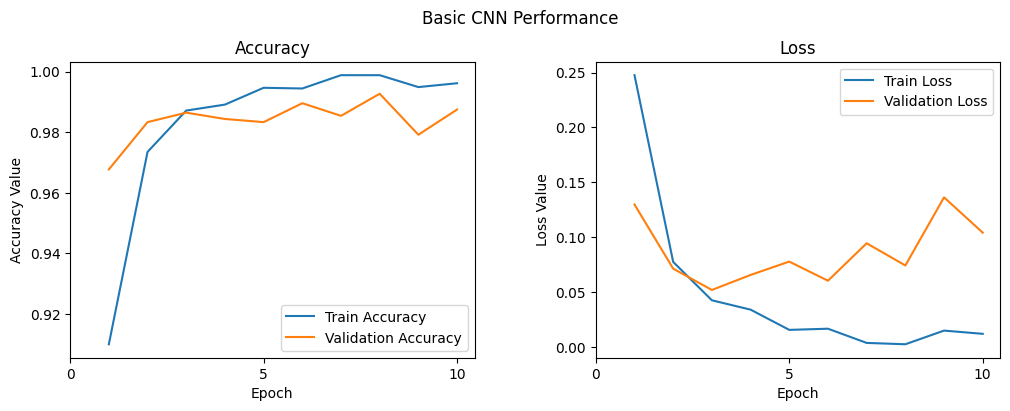

In [40]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1, 11))
ax1.plot(epoch_list, model.history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, model.history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 11, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, model.history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, model.history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 11, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

# Save the plot
plt.savefig(r"Results\images_cnn_model_performance.jpg")

# Model Saving

In [41]:
model_file_path = r"Models\images_cnn_model.h5"
# Save the model to the specified file path
model.save(model_file_path)

# Load trained model

In [ ]:
loaded_model = createModel()
loaded_model.load_weights(model_file_path)

# Getting model predictions : Classification Report

In [46]:
X_test_scaled.shape

(2400, 200, 200, 3)

In [73]:
# with tf.device('/CPU:0'):
# Getting model predictions
test_predictions = model.predict(X_test_scaled)
# preds = np.argmax(test_predictions, axis=1)

75/75 [==============================] - 2s 27ms/step


In [83]:
print(test_predictions)
print(test_predictions.shape)

[[8.3152940e-05]
 [1.0256801e-05]
 [9.9823242e-01]
 ...
 [5.3163880e-01]
 [1.0000000e+00]
 [3.6673178e-09]]
(2400, 1)
[0.9982324]


In [85]:
# preds = np.argmax(test_predictions, axis=1)
preds = []
for i in range(2400):
    if test_predictions[i] > 0.8:
        preds.append(1)
    else:
        preds.append(0)
preds = np.array(preds)
print(preds)
print(preds.shape)

[0 0 1 ... 0 1 0]
(2400,)


In [72]:
sum = 0
for i in range(2400):
    if Y_test[i] == 1:
        sum+=1
print(f"Number of test examples of class 'Tumor' = {sum}")
print(f"Number of test examples of class 'No Tumor' = {2400-sum}")

Number of test examples of class 'Tumor' = 1241
Number of test examples of class 'No Tumor' = 1159


In [86]:
# Convert actual_label to one-hot encoded format
actual_label = np.zeros((Y_test.shape[0], 2)) # [[1. 0.]] <==> [0] and opposite for [1]
actual_label[np.arange(Y_test.shape[0]), Y_test] = 1

In [87]:
# Convert preds to one-hot encoded format
preds_one_hot = np.zeros((preds.shape[0], 2)) # [[1. 0.]] <==> [0] and opposite for [1]
preds_one_hot[np.arange(preds.shape[0]), preds] = 1

print(classification_report(actual_label, preds_one_hot))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1159
           1       1.00      0.97      0.99      1241

   micro avg       0.99      0.99      0.99      2400
   macro avg       0.99      0.99      0.99      2400
weighted avg       0.99      0.99      0.99      2400
 samples avg       0.99      0.99      0.99      2400



# Showing Confusion Matrix

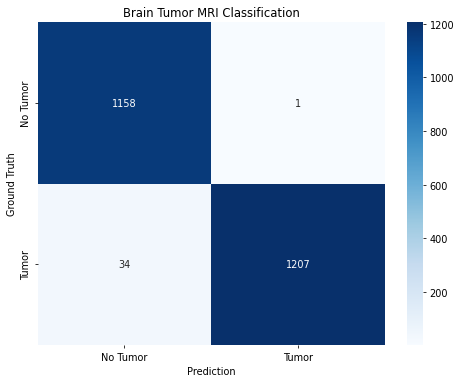

In [120]:
# Calculate confusion matrix
cnf = confusion_matrix(np.argmax(actual_label, axis=1), np.argmax(preds_one_hot, axis=1))

# Plot confusion matrix
labels = ["No Tumor", 'Tumor']
plt.figure(figsize=(8, 6), dpi=70, facecolor='w', edgecolor='k')
ax = sns.heatmap(cnf, cmap='Blues', annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.title('Brain Tumor MRI Classification')
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
# Save the plot
plt.savefig(r"Results\images_cnn_model_confusion_matrix.jpg")

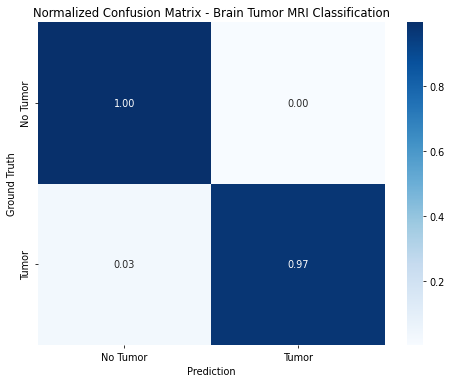

In [119]:
# Calculate confusion matrix
cnf = confusion_matrix(np.argmax(actual_label, axis=1), np.argmax(preds_one_hot, axis=1))
# Calculate row sums
row_sums = cnf.sum(axis=1, keepdims=True)
# Normalize confusion matrix
normalized_cnf = cnf / row_sums

# Plot confusion matrix
labels = ["No Tumor", 'Tumor']
plt.figure(figsize=(8, 6), dpi=70, facecolor='w', edgecolor='k')
ax = sns.heatmap(normalized_cnf, cmap='Blues', annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
plt.title('Normalized Confusion Matrix - Brain Tumor MRI Classification')
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
# Save the plot
plt.savefig(r"Results\images_cnn_model_normalised_confusion_matrix.jpg")

# Plotting roc curve

In [110]:
# Convert actual_label back to 1D array
actual_label_1d = np.argmax(actual_label, axis=1)

In [121]:
print(actual_label.shape)
print(actual_label_1d)
print(actual_label_1d.shape)
print(preds)
print(preds.shape)

(2400, 2)
[0 0 1 ... 1 1 0]
(2400,)
[0 0 1 ... 0 1 0]
(2400,)


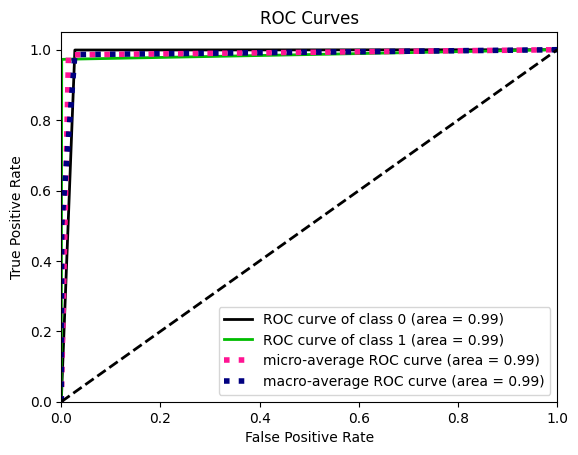

In [118]:
skplt.metrics.plot_roc(actual_label_1d, preds_one_hot)
# Save the plot
plt.savefig(r"Results\images_cnn_model_roc.jpg")

# Visualizing Model Predictions with Confidence

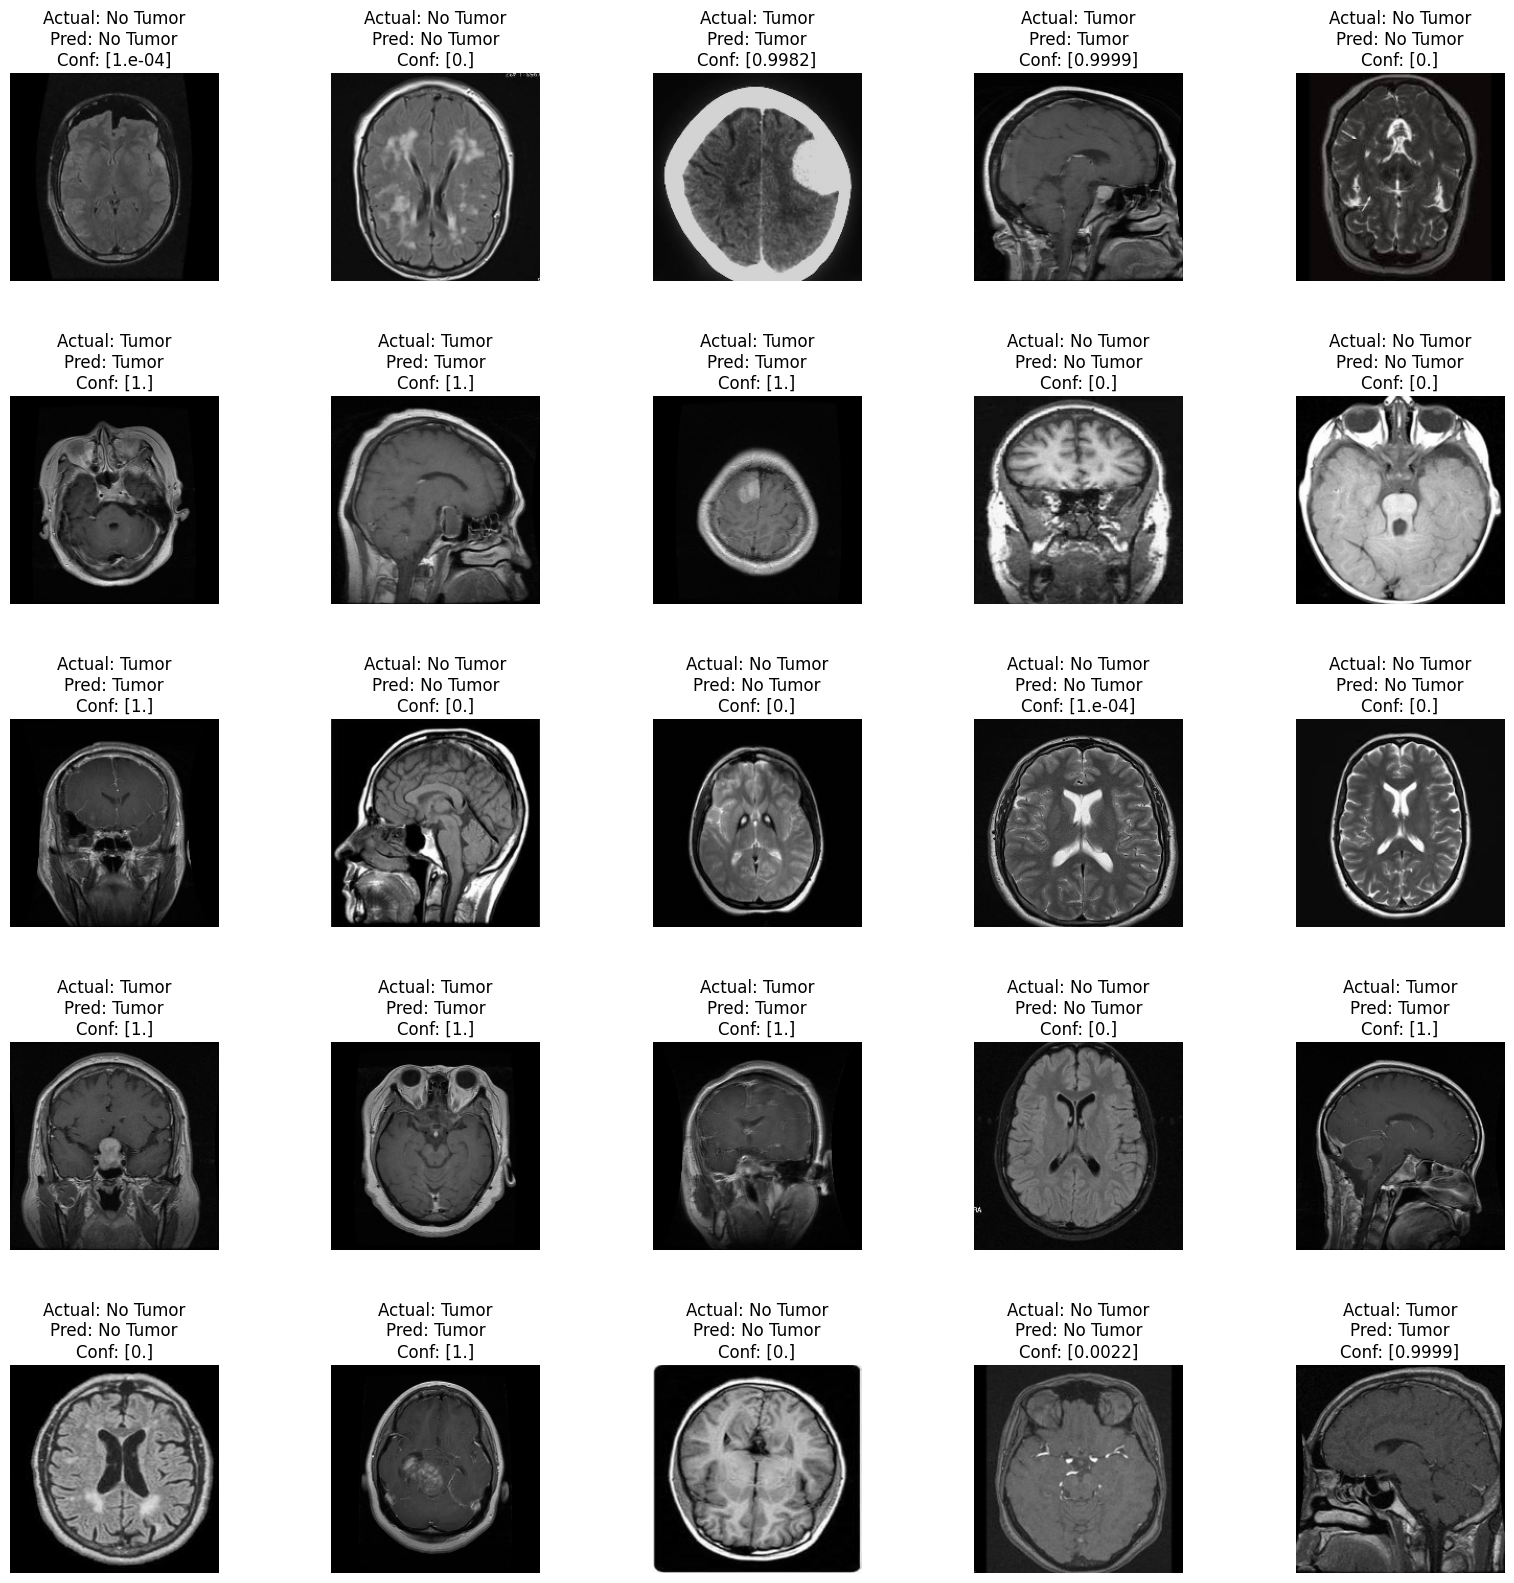

In [126]:
grid_width = 5
grid_height = 5
f, ax = plt.subplots(grid_width, grid_height)
f.set_size_inches(15, 15)

img_idx = 0
for i in range(0, grid_width):
    for j in range(0, grid_height):
        actual = actual_label_1d[img_idx]
        predicted = preds[img_idx]
        confidence = np.round(test_predictions[img_idx], 4)
        ax[i][j].axis('off')
        ax[i][j].set_title('Actual: '+labels[actual]+'\nPred: '+labels[predicted] + '\nConf: ' +str(confidence))
        ax[i][j].imshow(X_test[img_idx])
        img_idx += 1

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.5, hspace=0.55)
plt.savefig(r"Results\images_cnn_model_confidence.jpg")